In [2]:
#python libraries
import os
import re

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

/home/henrikhestnes/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", "Temperature"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True).dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)

            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)

            if measurement_type  == "Temperature":
                measurement_frame  = measurement_frame.resample('5T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..
                sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  
    

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()


array([[<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>]], dtype=object)

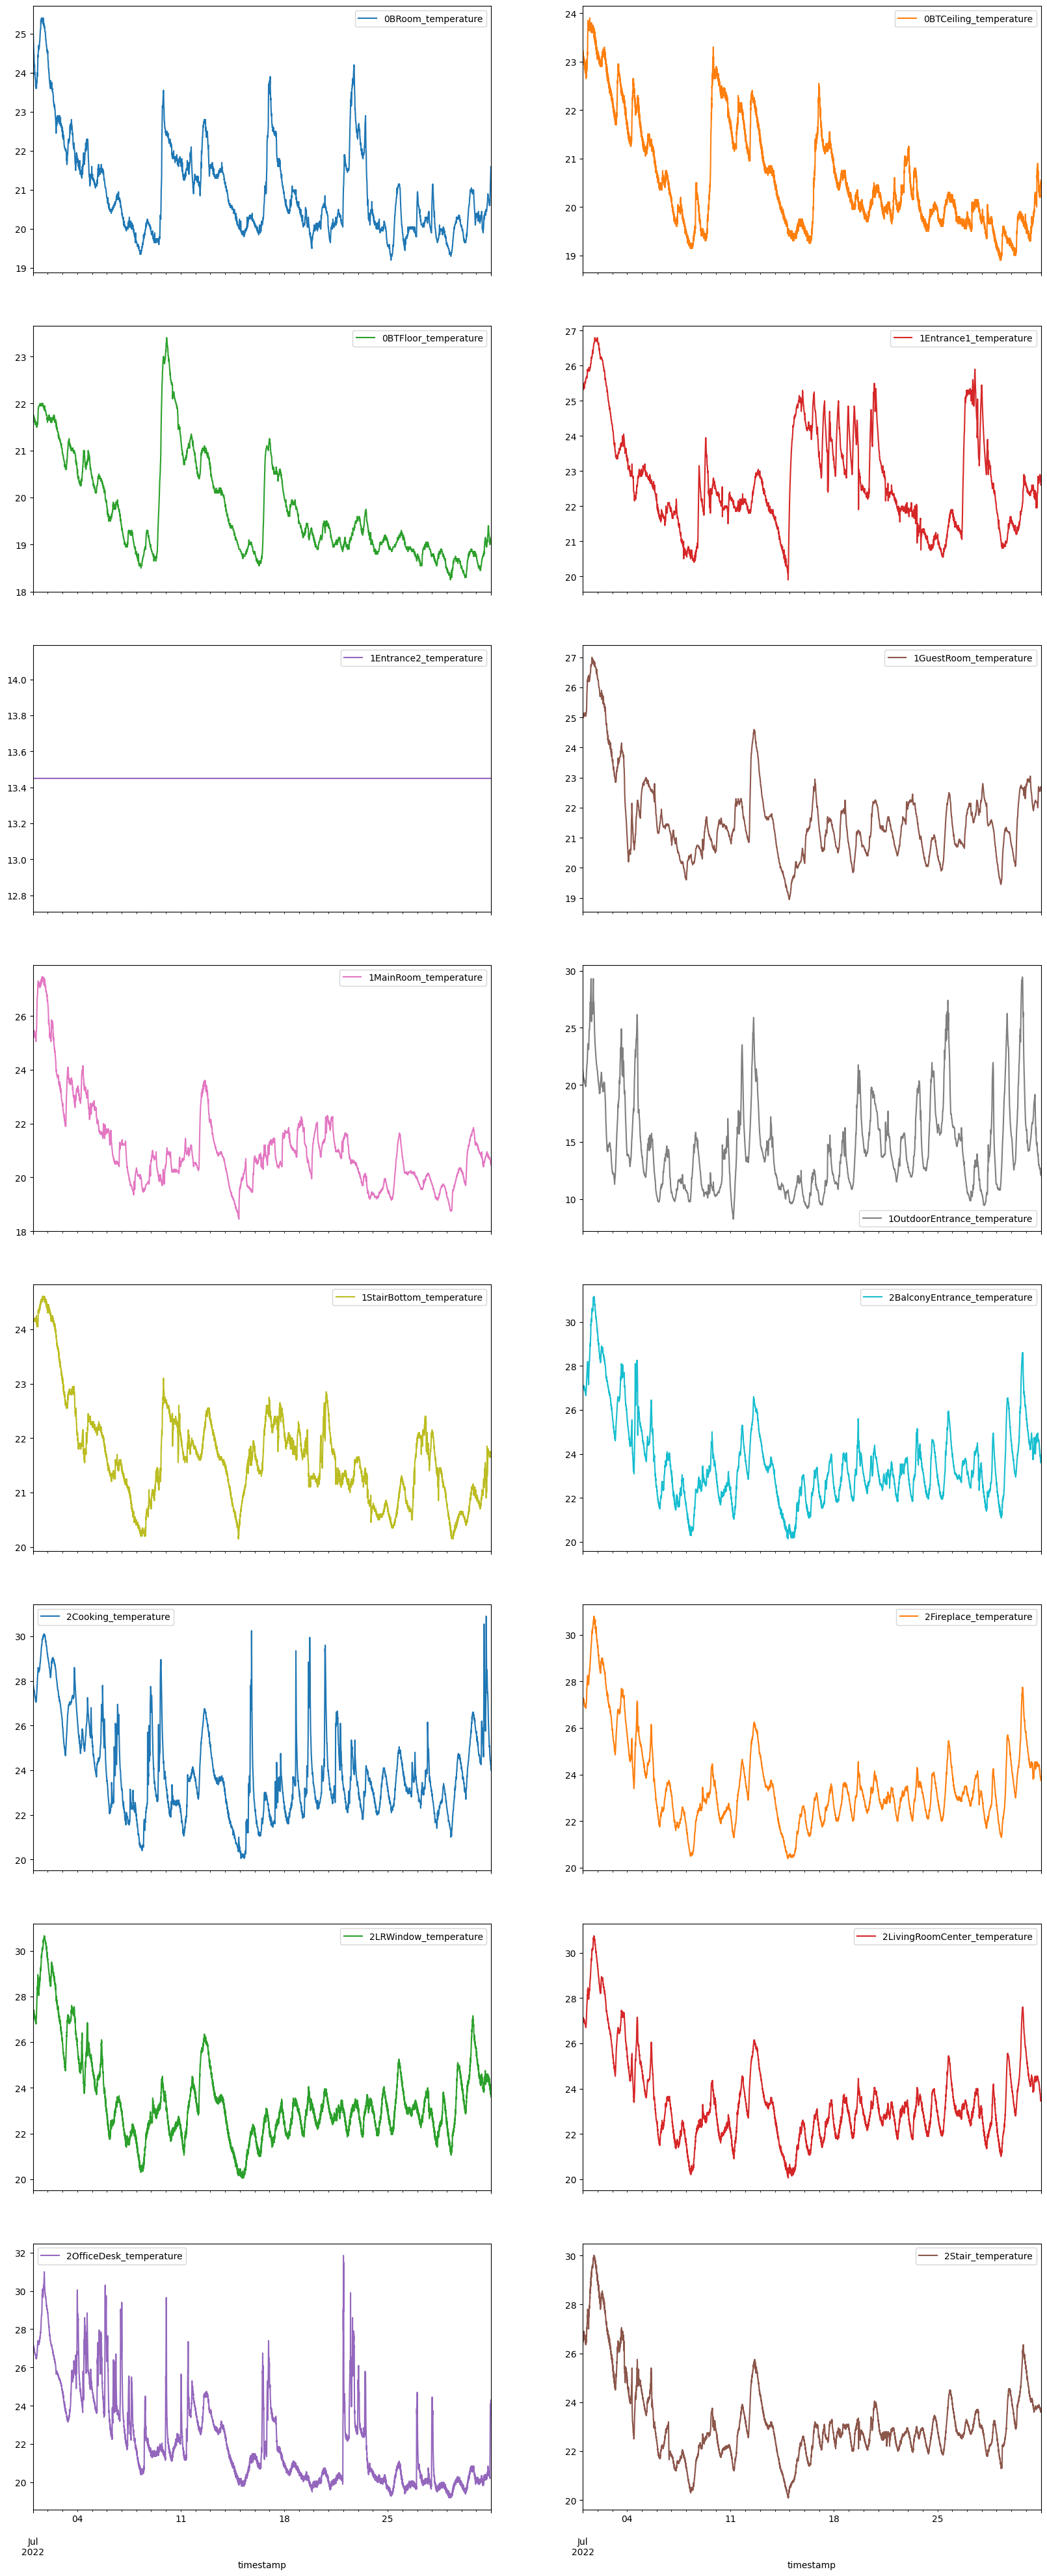

In [25]:
sensor_data.loc[sensor_data.index.month == 7].plot(subplots=True, layout=(8, 2), figsize=(20, 50))

array([[<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,


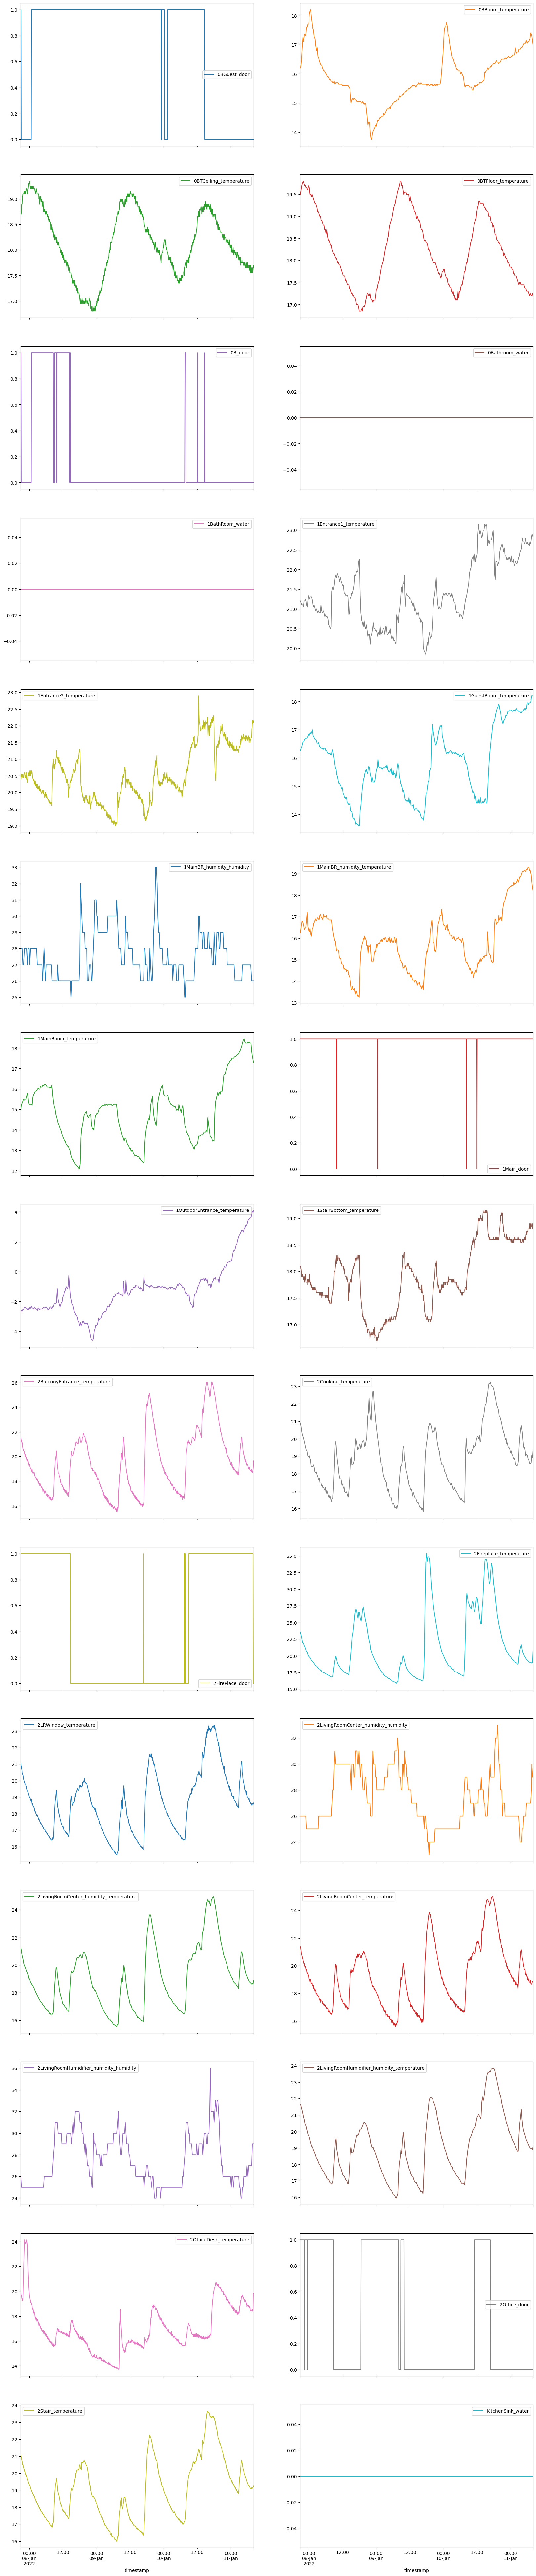

In [5]:
#Saving sensor_data plot to sensor_data.pdf
sensor_data.head(1000).plot(subplots=True, layout=(15, 2), figsize=(20, 100))

In [5]:
print(f"Shape of DataFrame: {sensor_data.shape}")
sensor_data.head(2)

Shape of DataFrame: (67961, 30)


,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1Entrance2_temperature,1GuestRoom_temperature,...,2LRWindow_temperature,2LivingRoomCenter_humidity_humidity,2LivingRoomCenter_humidity_temperature,2LivingRoomCenter_temperature,2LivingRoomHumidifier_humidity_humidity,2LivingRoomHumidifier_humidity_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,KitchenSink_water
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-07 20:50:00+01:00,1.0,16.2,18.65,19.5,1.0,0.0,0.0,21.2,20.500,16.25,...,20.95,26.0,21.3,21.40,26.0,21.65,19.80,1.0,21.15,0.0
2022-01-07 20:55:00+01:00,1.0,16.2,18.70,19.5,1.0,0.0,0.0,21.2,20.525,16.25,...,20.95,26.0,21.3,21.35,26.0,21.65,19.75,1.0,21.15,0.0
